In [1]:
from evaluation.evaluation import evaluate
from pathlib import Path
import torch


class Args(object):
    def __init__(self):
        self.name = "exp_11"
        self.resolution = 256
        self.load_checkpoint = True
        self.train = False
        self.dataset_path = Path("./dataset")
        self.results_dir = Path("./output")
        self.pretrained_models_path = Path("./pretrained")
        self.train_data_size = 50000
        self.batch_size = 3
        self.reals = False
        self.test_real_attr = True
        self.train_real_attr = False
        self.weights_dir = self.results_dir.joinpath(self.name+"/weights")
        self.cache = True
        self.parameter_embedding = False


args = Args()
configs = {
    "id_model_path": str(args.pretrained_models_path.joinpath("20180402-114759-vggface2.pt")),
    "stylegan_G_path": str(args.pretrained_models_path.joinpath("stylegan2-ffhq-256x256.pkl")),
    "landmarks_model_path": str(args.pretrained_models_path.joinpath('3DDFA/phase1_wpdc_vdc.pth.tar')),
    "batch_size": args.batch_size
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AttrEncoder loads checkpoint from: output/exp_11/weights/AttrEncoder.pth
ReferenceNetwork load checkpoint from: output/exp_11/weights/ReferenceNetwork.pth


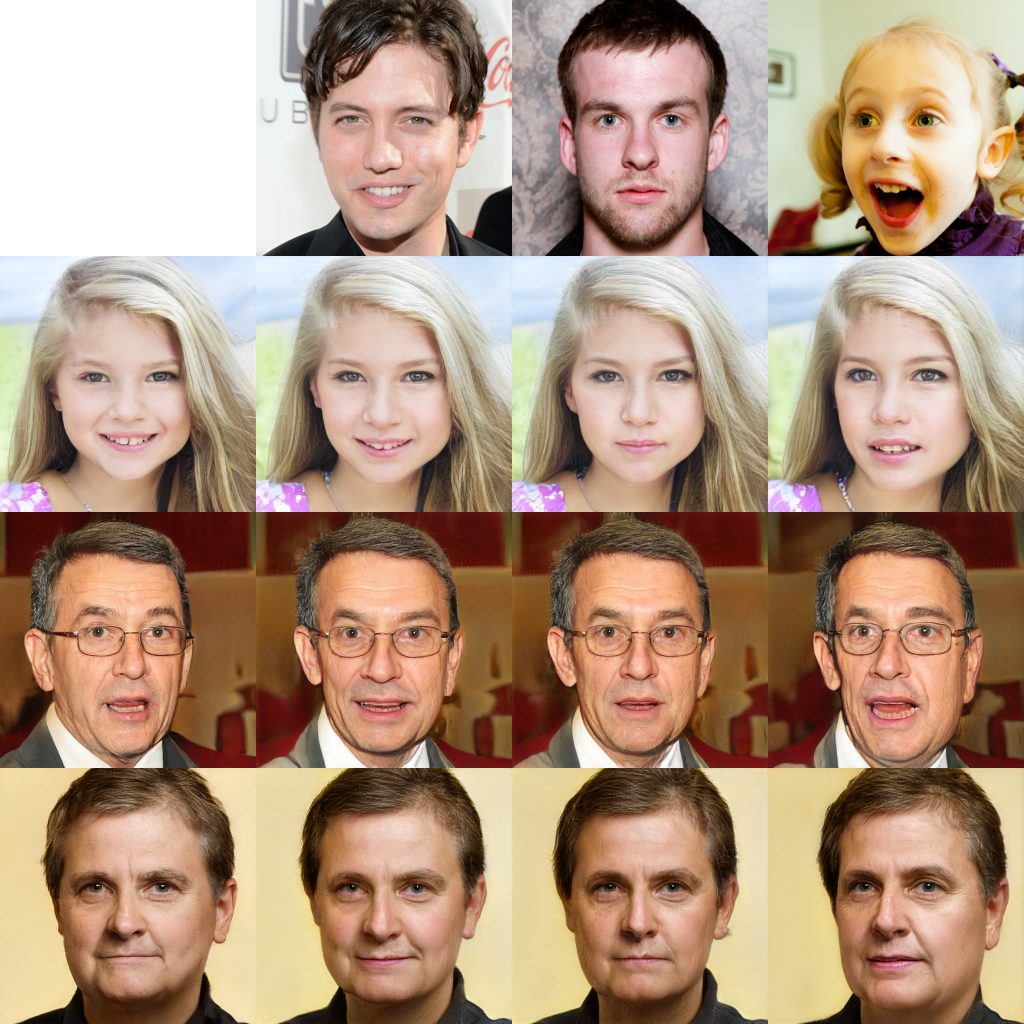

In [2]:
import torchvision.transforms.functional as TF

a = evaluate(args, configs, device)
TF.to_pil_image(a)

In [ ]:
from metrics.frechet_inception_distance import FIDScore
import torch
from pathlib import Path
from model.generator import Generator


class Args(object):
    def __init__(self):
        self.name = "exp_17 - conv0--4"
        self.resolution = 256
        self.load_checkpoint = True
        self.train = False
        self.dataset_path = Path("./dataset")
        self.results_dir = Path("./output")
        self.pretrained_models_path = Path("./pretrained")
        self.train_data_size = 50000
        self.batch_size = 6
        self.reals = False
        self.test_real_attr = True
        self.train_real_attr = False
        self.weights_dir = self.results_dir.joinpath(self.name+"/weights")
        self.cache = True
        self.parameter_embedding = False


args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

id_model_path = str(args.pretrained_models_path.joinpath(
    "20180402-114759-vggface2.pt"))
stylegan_G_path = str(args.pretrained_models_path.joinpath(
    "stylegan2-ffhq-256x256.pkl"))
landmarks_model_path = str(
    args.pretrained_models_path.joinpath('3DDFA/phase1_wpdc_vdc.pth.tar'))

G = Generator(args=args, id_model_path=id_model_path, base_generator_path=stylegan_G_path, landmarks_detector_path=landmarks_model_path,
              device=device)

G._load("")

fid_score = FIDScore(args, G, device)

In [ ]:
fid = fid_score.calculate_fid(num_gen=10000)

In [ ]:
fid

In [ ]:
from model import landmarks_detector, networks_stylegan2, id_encoder, attr_encoder, reference_autoencoder, reference_network
from general_utils import legacy
import torchvision.transforms.functional as TF
from data_loader.gen_data import GeneratedDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import torch
import dnnlib
import random
from pathlib import Path
import numpy as np


class Args(object):
    def __init__(self):
        self.name = "exp_07"
        self.resolution = 256
        self.load_checkpoint = True
        self.train = False
        self.dataset_path = Path("./dataset")
        self.results_dir = Path("./output")
        self.pretrained_models_path = Path("./pretrained")
        self.train_data_size = 50000
        self.batch_size = 6
        self.reals = False
        self.test_real_attr = True
        self.train_real_attr = False
        self.weights_dir = self.results_dir.joinpath(self.name+"/weights")


args = Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_id_attr_sampler(dataset_length, cross_frequency):
    split = dataset_length // (cross_frequency + 1)
    id_dataset_length = dataset_length - split
    indices = list(range(dataset_length))
    random.shuffle(indices)
    id_sampler = SubsetRandomSampler(indices[split:])
    attr_sampler = SubsetRandomSampler(indices[:split])
    return id_sampler, attr_sampler, id_dataset_length


id_model_path = str(args.pretrained_models_path.joinpath(
    "20180402-114759-vggface2.pt"))
stylegan_G_path = str(args.pretrained_models_path.joinpath(
    "stylegan2-ffhq-256x256.pkl"))
landmarks_detector_path = str(
    args.pretrained_models_path.joinpath('3DDFA/phase1_wpdc_vdc.pth.tar'))

# Load style generator and freeze its parameters
with dnnlib.util.open_url(stylegan_G_path) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].to(device)

stylegan_generator = networks_stylegan2.Generator(**G.init_kwargs).to(device)
stylegan_generator.load_state_dict(G.state_dict())
stylegan_generator.eval()

for param in stylegan_generator.parameters():
    param.requires_grad = False

# Load identity encoder and freeze its parameters
_id_encoder = id_encoder.ID_Encoder(args, id_model_path).to(device)
_id_encoder._test()

# Inintialize attribute encoder
_attr_encoder = attr_encoder.AttrEncoder(args).to(device)

# Load landmarks detector and freeze its parameters
_landmarks_detector = landmarks_detector.LandmarksDetector(
    args, landmarks_detector_path).to(device)
_landmarks_detector._test()

_reference_network = reference_network.ReferenceNetwork(args).to(device)

In [ ]:
from data_loader.ffhq_data import FFHQDataset
from torch.utils.data.dataloader import DataLoader

ffhq_dataset = FFHQDataset(args)
ffhq_dataloader = DataLoader(ffhq_dataset, batch_size=6, pin_memory=True)
ffhq_iter = iter(ffhq_dataloader)

In [ ]:
imgs = next(ffhq_iter)

In [ ]:
import cv2 as cv

id_image = cv.imread("./dataset/gen_dataset/image/1000/3.png")
id_image = torch.from_numpy(id_image.transpose(
    (2, 0, 1))).float().flip(-3).to(device)
id_image.sub_(127.5).div_(128)
attr_image = cv.imread("./dataset/gen_dataset/image/1000/1.png")
attr_image = torch.from_numpy(attr_image.transpose(
    (2, 0, 1))).float().flip(-3).to(device)
attr_image.sub_(127.5).div_(128)

id_image = torch.broadcast_to(id_image, (6, *id_image.shape))
attr_image = torch.broadcast_to(attr_image, (6, *attr_image.shape))

id_embd = _id_encoder(id_image)
attr_embd = _attr_encoder(attr_image)

control_vector = _reference_network(attr_embd)

In [ ]:
z = torch.from_numpy(np.random.RandomState(3).randn(512)).to(device)
z = torch.broadcast_to(z, (6, *z.shape))

gen_images = stylegan_generator(z, control_vector)
pts68, pose, idx_list = _landmarks_detector(gen_images)